## Load and Conversion

In this notebook, we convert the network trained according to Patel et al. [1]. The results, even though not calculated in the previous experiment are included in our result directory. We load the best performing agent and convert it for the conventionally trained DQN. Additionally, we load the best performing directly trained DSQN agent for comparison. It can be seen that all agents follow the same strategy of hitting the left border and then staying there. Therefore, they all achieve very similar scores.

In [1]:
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
# hack to perform relative imports
sys.path.append('../../')
from Code import load_agent, SQN
# we first load the trained DQN
# bestavgsofar contains the best models during training
# trained13532 is the best model which can be seen from the terminal output (scroll to bottom)
os.chdir('./../../Results/Breakout-Patel-DQN/best_avg_models/trained13532')

# set seeds
torch.manual_seed(1)
random.seed(1)
gym_seed = 1

# set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Detected PyNN version 0.9.5 and Neo version 0.6.1


### Load 

In [2]:
# we need to use our legacy DQN class, because of changes made later to the code
import torch.nn as nn
import torch.nn.functional as F
class FFDQN(nn.Module):
    """The DQN for the original BreakOut problem"""

    def __init__(self):
        super(FFDQN, self).__init__()
        self.l1 = nn.Linear(80*80, 1000, bias=True)
        self.l2 = nn.Linear(1000, 4, bias=True)
        # self.apply(weights_init_uniform)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.detach().clone().float()
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

    def forward_return_all(self,x):
        x = x.reshape(6400,)
        x = x.detach().clone().float()
        all_neurons_output = []
        x = F.relu(self.l1(x))
        all_neurons_output.append(x)
        x = self.l2(x)
        all_neurons_output.append(x)
        return all_neurons_output

env = 'BreakoutDeterministic-v4'

# load the network, take care that you choose the same architecture and class as the model that is loaded
policy_net = FFDQN()
policy_net.load_state_dict(torch.load('model.pt',map_location=device))


<All keys matched successfully>

In [3]:
# we load the agent with epsilon=0.1 such that it does not get stuck because it never fires a new ball
EPSILON = 0.1
# define input preprocessing: grayscale processing according to Patel
from skimage.transform import resize
def input_preprocessing(observation_history):
    def rgb2gray(rgb):
        """converts a coloured image to gray"""
        # extract the luminance
        image = rgb[:, :, 0] * 0.2126 + rgb[:, :, 1] * 0.7152 + rgb[:, :, 2] * 0.0722
        # crop the image
        image = image[25::, :]
        # downsize to 80x80
        image_resized = resize(image, (80, 80))
        # return the processed image and the new prev frame
        return image_resized
    preprocessed = rgb2gray(observation_history[0]) + 0.75 * rgb2gray(observation_history[1]) + 0.5 * rgb2gray(observation_history[2]) + 0.25 * rgb2gray(observation_history[3])
    # rescale such that maximum value is 255 for conversion to uint8
    preprocessed[preprocessed>255] = 255
    preprocessed = torch.tensor(preprocessed,device=device,dtype=torch.uint8)
    # cast to tensor of shape (6400,) to be processed correctly by the SQN
    preprocessed = preprocessed.reshape(6400,)
    return preprocessed.float()

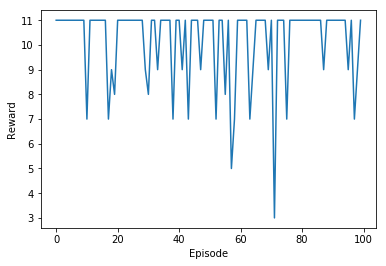

Complete
Mean:  10.21
Std:  1.5846167047617858


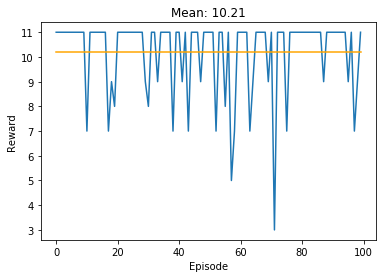

In [21]:
# need to save the replay memory, because it is not included in results as it exceeds the github file size limit
# also need to set correct values for frameskip and no_ops
load_agent(env,policy_net,device,save_replay=True,epsilon=EPSILON, input_preprocessing=input_preprocessing,
           frameskip=4,no_op_range=(4,30),no_op=0,observation_history_length=4)

### Load converted DQN
<div class="alert alert-block alert-warning">
<b>Attention:</b> Make sure that you saved the replay memory in the previous cell, because the results folder does not provide the replay memory as it exceeds the file limit from Github (100MB)
</div>

In [22]:
# this cell converts the network, we do not use it however because we converted the network 
# beforehand and can simply load it
'''# convert the network
from Code import weight_conversion, save_model
# choose the conversion method ('robust','model', or 'data')
CONVERSION_METHOD = 'robust' 
# for robust we additionally need to specify the path to the replay and the ppercentile
path_to_replay = './Replay_Memory' # needed for data-based and robust
ppercentile = 0.99
# for the conversion the weights and biases need to be provided in the form [W1,W2,..,Wn] and [b1,b2,...,bn]
weights = []
biases = []
# need to append manually, because of legacy DQN class
weights.append(policy_net.l1.weight.data.detach().clone())
weights.append(policy_net.l2.weight.data.detach().clone())
biases.append(policy_net.l1.bias.data.detach().clone())
biases.append(policy_net.l2.bias.data.detach().clone())

# call the weight conversion method provided in the SQN module
converted_weights, converted_biases = weight_conversion(policy_net,weights,biases,device, 
                                                        normalization_method=CONVERSION_METHOD,
                                                        ppercentile=ppercentile,path_to_replay=path_to_replay)
# set up the spiking network
architecture = [6400,1000,2]
converted = SQN(architecture,device,alpha=0.0,beta=1.0,simulation_time=100,add_bias_as_observation=False,
                  encoding='constant',decoding='potential',reset='subtraction',threshold=1.0)
# load the converted weights
converted.load(converted_weights,converted_biases)
# save the network
save_model(converted,'converted')'''

"# convert the network\nfrom Code import weight_conversion, save_model\n# choose the conversion method ('robust','model', or 'data')\nCONVERSION_METHOD = 'robust' \n# for robust we additionally need to specify the path to the replay and the ppercentile\npath_to_replay = './Replay_Memory' # needed for data-based and robust\nppercentile = 0.99\n# for the conversion the weights and biases need to be provided in the form [W1,W2,..,Wn] and [b1,b2,...,bn]\nweights = []\nbiases = []\n# need to append manually, because of legacy DQN class\nweights.append(policy_net.l1.weight.data.detach().clone())\nweights.append(policy_net.l2.weight.data.detach().clone())\nbiases.append(policy_net.l1.bias.data.detach().clone())\nbiases.append(policy_net.l2.bias.data.detach().clone())\n\n# call the weight conversion method provided in the SQN module\nconverted_weights, converted_biases = weight_conversion(policy_net,weights,biases,device, \n                                                        normalization_

In [23]:
# load the converted network
architecture = [6400,1000,2]
converted = SQN(architecture,device,alpha=0.0,beta=1.0,simulation_time=100,add_bias_as_observation=False,
                  encoding='constant',decoding='potential',reset='subtraction',threshold=1.0,two_input_neurons=False)
# load the saved weights
path_to_converted_dqn = './converted/model.pt'
converted.load_state_dict(torch.load(path_to_converted_dqn))

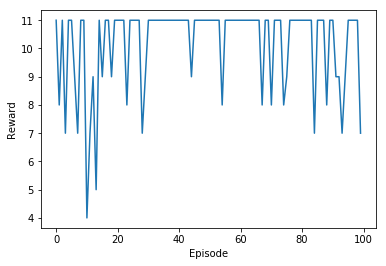

Similarity (Conversion Accuracy) after 42192 iterations: 100.0%
Complete
Mean:  10.18
Std:  1.5333333333333332
Similarity (Conversion Accuracy) after 42192 iterations: 100.0%


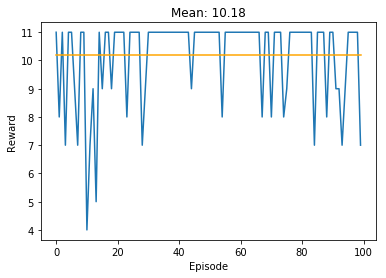

In [28]:
# load the spiking agent and compare against original DQN                                                
# simulate the spiking network 
load_agent(env,converted,device,epsilon=0.1,gym_seed=gym_seed,save_replay=False,
           num_episodes=100, render=True, compare_against=policy_net, frameskip=4,
           observation_history_length=4,no_op_range=(4,30),no_op=0,input_preprocessing=input_preprocessing)

### Load directly trained DSQN

In [4]:
# switch to the directory the DSQN is saved at, careful: the directory was changed before, so set the relative part 
# carefully, if you want to change it.
# trained5978 contains the best model from training as can be seen from the terminal output (scroll to the bottom)
os.chdir('./../../../Breakout-Patel-DSQN/best_avg_models/trained5978')
# Initialize the policy net. Make sure you use the same hyperparameters as for the model that is loaded, unless
# you intend to test the model for robustness against these parameters.
architecture = [6400,1000,4]
# we additionally need to set has_biases to False, because it represents a special case for loading
policy_net = SQN(architecture, device=device, alpha=0, beta=1, simulation_time=20,
                  add_bias_as_observation=False, encoding='constant',decoding='potential',
                  reset='subtraction',threshold=1)
# instead of load_state_dict we call load, as the saved DSQN has been trained with legacy code where the network 
# is saved in the form (w1,w2,w3) instead of ((w1,w2,w3),(b1,b2,b3)). We then define the biases manually to 
# (None,None,None). Also we have to suppress transposing as it is used when loading converted networks.
policy_net.load(torch.load('model.pt',map_location='cpu'),[None]*3,transpose=False)

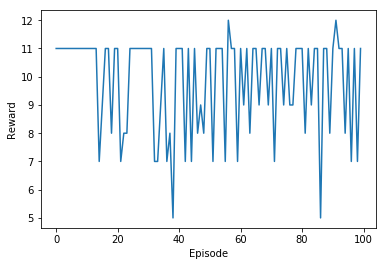

Complete
Mean:  9.88
Std:  1.7013363731330304


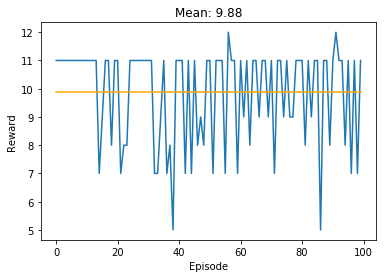

In [5]:
load_agent(env,policy_net,device,save_replay=False,epsilon=EPSILON, input_preprocessing=input_preprocessing,
           frameskip=4,no_op_range=(4,30),no_op=0,observation_history_length=4)

[1] Devdhar Patel, Hananel Hazan, Daniel J. Saunders, Hava T. Siegelmann, and Robert Kozma. Improved robustness of reinforcement learning policies upon conversion to spiking neuronal network platforms applied to Atari Breakout game. Neural Networks, 2019.